## 프로젝트 : CIFAR-10 이미지 생성하기
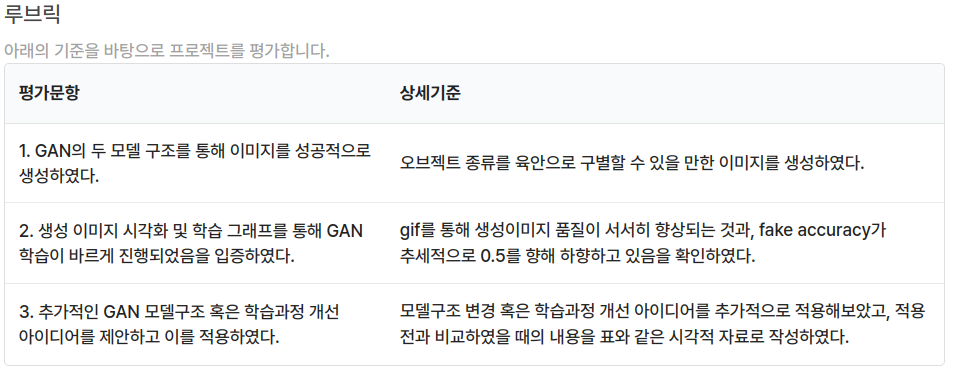

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)
print("imageio", imageio.__version__)

tensorflow 2.6.0
imageio 2.9.0


### STEP 1. 작업환경 구성하기

In [2]:
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

### STEP 2. 데이터셋 구성하기

In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

print(train_x.shape)
print(test_x.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [4]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [5]:
# 정규화 
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


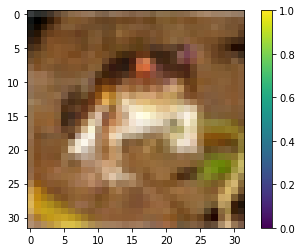

In [7]:
plt.imshow((train_x[0]+1)/2)
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers) 경고가 떴었는데,    
'uint8'로 타입을 변경해주니 경고는 사라졌지만 이미지가 전부 검정색으로 바뀌었다. train_x[0]을 뽑아보니 전부 0이 되어있다. 다시 float32로 변경해주었다. 

Ref.   
https://ufris.tistory.com/11

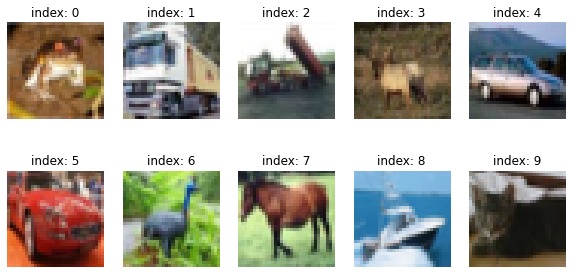

In [8]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_x[i]+1)/2)
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

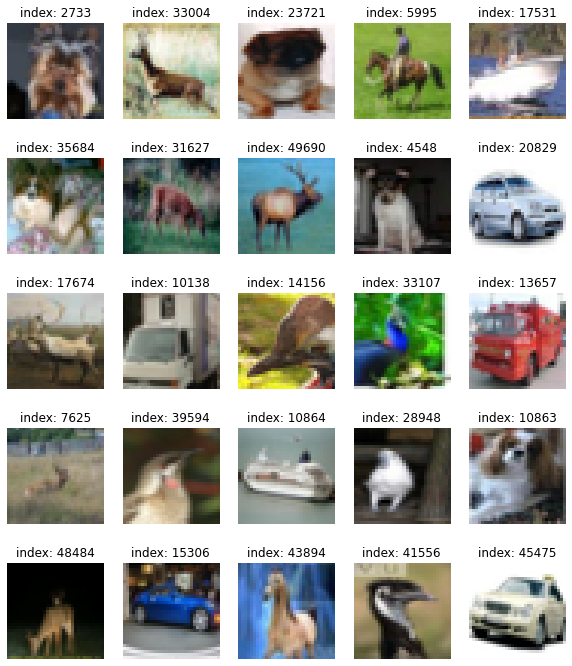

In [9]:
import random

plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    np.random.seed(i)  # seed 로 고정된 랜덤 사용
    random_i = np.random.randint(1, len(train_x))
    plt.imshow((train_x[random_i]+1)/2)
    plt.title(f'index: {random_i}')
    plt.axis('off')

plt.show()

In [10]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

- 학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.
- 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.
학습 시간이 너무 오래 걸린다면 한 종류의 데이터만 추출해 진행해도 좋습니다. 아래 코드는 참고만 하세요.

### STEP 3. 생성자 모델 구현하기

In [12]:
# 생성자 모델 정의 
def make_generator_model():

    g_kernel_size = 4
    g_LeakyReLU_alpha = 0.2

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer  # 32=8*4 이므로 8
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(512, kernel_size=(g_kernel_size, g_kernel_size), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Seventh: Conv2DTranspose layer  # output channel 설정
    model.add(layers.Conv2D(3, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [13]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 512)         2097152   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 512)         0

처음에 Dense층을 7*7*256로 넣어주었더니, 출력된 shape이 (28, 28, 3)이 되었다.    
(32, 32, 3)로 바꾸기 위해 4*4*256로 바꾸고 kernel_size=(4, 4), strides=(2, 2)로 바꾸니 (32, 32, 3)가 되었다.      
결과를 보면서 숫자를 하나하나 바꾸는 방법 밖에 없을까?

Ref)   
https://github.com/adele2020/ssacxaiffel/blob/main/%5BE12%5D_CIFAR-10_generation.ipynb

In [14]:
noise = tf.random.normal([1, 100])

In [15]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

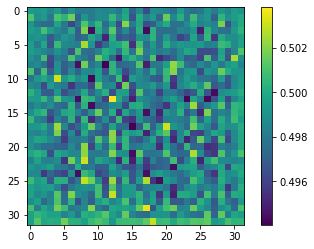

In [16]:
plt.imshow((generated_image[0, :, :, 0]+1)/2)
plt.colorbar()
plt.show()

### STEP 4. 판별자 모델 구현하기

In [17]:
# 판별자 모델 
def make_discriminator_model():

    d_kernel_size = 3
    d_LeakyReLU_alpha = 0.2
    d_dropout_rate = 0.5

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (d_kernel_size, d_kernel_size), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (d_kernel_size, d_kernel_size), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, (d_kernel_size, d_kernel_size), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # Fourth: Conv2D Layer
    model.add(layers.Conv2D(256, (d_kernel_size, d_kernel_size), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # FIfth: Flatten Layer
    model.add(layers.Flatten())

    # sixth: Dense Layer  # 숫자 1개(진짜라고 판단되는 정도)
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [18]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)        

In [19]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49994802]], dtype=float32)>

### STEP 5. 손실함수와 최적화 함수 구현하기

In [20]:
# 손실함수
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
# 생성자 손실함수 
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
# 왜 ones_like를 tf.constant(0.9, shape=real_output.shape)로 바꿔줬을까?
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [23]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [24]:
# 최적화 함수 
LR = 1e-4  
BETA_1=0.5

generator_optimizer = tf.keras.optimizers.Adam(LR, BETA_1, amsgrad=True)
discriminator_optimizer = tf.keras.optimizers.Adam(LR, BETA_1, amsgrad=True)

beta_1 : 0보다 크고 1보다 작은 float 값. 일반적으로 1에 가깝게 설정
Ref.    
https://keras.io/ko/optimizers/

In [25]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### STEP 6. 훈련과정 상세 기능 구현하기

In [26]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [27]:
def generate_and_save_images(model, epoch, it, sample_seeds, save_file_num=1):

    predictions = model(sample_seeds, training=False)  # 16개의 seed 가 들어있는 sample_seeds
    
    # [-1,1]로 정규화된 이미지를 원상복구함
    rescue_predictions = (predictions.numpy() * 127.5 + 127.5).astype(int)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)  # 16개 sample 이라서 4행 4열로 시각화
        plt.imshow(rescue_predictions[i])  
        plt.axis('off')
   
    plt.tight_layout()  # subplot 간격 자동 조절(겹치지 않게)

    save_file_path = '/aiffel/dcgan_newimage/cifar10/generated_samples/sample_{}'.format(save_file_num)
    if not os.path.exists(save_file_path):
        os.makedirs(save_file_path)
    
    save_file_path = os.path.join(save_file_path, 'sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    plt.savefig(save_file_path)  # 이미지 저장

    plt.show()

In [29]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    plt.tight_layout()  # subplot 간격 자동 조절(겹치지 않게)
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [30]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### STEP 7. 학습 과정 진행하기

In [31]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [32]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

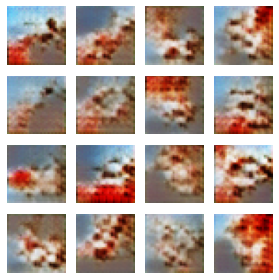

Time for training : 8480 sec


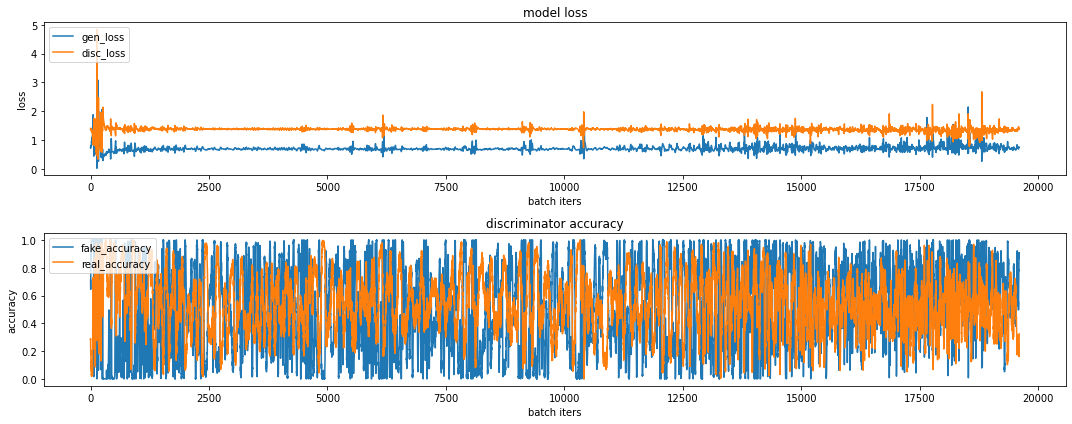

CPU times: user 2h 21min 41s, sys: 4min 3s, total: 2h 25min 44s
Wall time: 2h 21min 22s


In [33]:
%%time
train(train_dataset, EPOCHS, save_every)

In [41]:
# 생성된 이미지 gif
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/dcgan_newimage/cifar10/generated_samples/sample_1/sample_*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 2265878 Mar  3 13:47 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


In [45]:
# history gif
history_anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_history.gif'

with imageio.get_writer(history_anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_history.gif

-rw-r--r-- 1 root root 1598233 Mar  3 14:44 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_history.gif


checkpoint를 통해 모델이 로드되었으면 아래 코드를 실행할 경우 로드된 모델의 파라미터 상태에서 훈련을 재개할 수도 있습니다.

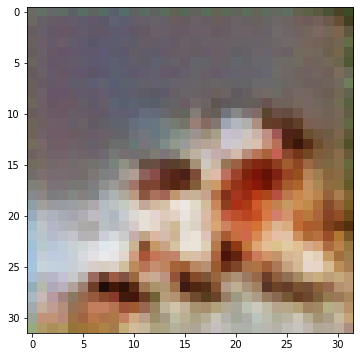

In [36]:
# 모델 돌아간 다음에 checkpoint 생성  
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

### STEP 8. (optional) GAN 훈련 과정 개선하기
- gif 파일은 github 폴더에 업로드했습니다. 

1. 생성한 이미지의 정체가 가 도대체 뭔지 알 수 없다.     
=> epoch을 100번 돌렸는데, 500번 정도 돌리면 조금 더 선명해질 것 같다. 

2. fake accuracy가 0.5를 향해 하향하는지 애매하다. 오히려 초반에 0.2~0.4에 분포하는 파란색이 더 많은 것으로 보아 1에 가깝게 상승하고 있는 것 같다.      
=> 이 경우에는 epoch을 더 돌린다고 다시 하향할 것 같지 않다. 모델 구성을 바꾸던지 근본적인 것을 해결해야 할 것 같다. 

## 회고

**헤맨 부분** 
- 전반적으로 너무 어려워서 그 어떤 부분도 제대로 이해했다는 생각이 들지 않는다. 
- 생성자, 판별자 shape을 (32, 32, 3)로 만드는 과정에서, 숫자를 어떻게 바꿔도 안됐다. 결국 다른 사람의 코드를 참고하는 수 밖에 없었다. 
- mnist와 달리 cifar10은 class가 많아서 손실함수로 sparse categorical crossentropy를 써야한다고 생각했는데, 어차피 결론은 진짜, 가짜 판별이므로 binary crossentropy를 써야한다.  
- 생성한 animated GIF를 주피터에 출력해야할 것 같은데, 아무리 찾아봐도 도무지 어떻게 할지 모르겠다. 여러 방법을 시도해보다 실패해 github에 gif 파일을 각각 따로 업로드했다. 

**문제를 해결하기 위한 시도와 원인 추론**
- Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers) 경고를 없애고 싶어서 astype('uint8')로 바꿔보았는데, 픽셀값이 전부 0으로 변해서 이미지가 까맣게 출력되었다. float32로 다시 바꿔주었다. int는 정수라 0에 가까운 소수들을 모두 0으로 바꿔서 그런 것 같다. 

**새롭게 알게된 부분**
- 이미지 생성은 매우 어렵다. 모델을 제대로 만들지 않는 이상 아무리 많은 epoch을 돌려도 문제는 해결되지 않는다. 
- 모델이 너무 깊어지면 오히려 이미지 생성이 잘 안된다. 

**아직도 모르는 부분**
- train할 때 이미지가 계속 파랗게 출력되어 다른 사람들의 코드를 참조해서 바꿔주었다. 도대체 어떤 부분이 달라서 그런 문제가 생기는지 여전히 모르겠다. 
- 생성자, 판별자 모델 만들 때 shape을 (32, 32, 3)로 변형하기 위해 숫자 구성을 바꿔야되는데, 원하는 숫자가 나올때까지 하나씩 해보는 방법 말고, 모델의 성능이 좋아지도록 만드는 방법이 없을까?